In [9]:
# get the model from github
!git clone https://github.com/AntonioSkara132/LangPathModel.git

Cloning into 'LangPathModel'...
remote: Enumerating objects: 583, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 583 (delta 1), reused 1 (delta 0), pack-reused 577 (from 1)
Receiving objects: 100% (583/583), 165.54 MiB | 29.23 MiB/s, done.
Resolving deltas: 100% (314/314), done.


### **Initialization**

In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline
!apt-get -y update && apt-get -y install ffmpeg


Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

###**Dataset Creation**

In [11]:
!git clone https://huggingface.co/datasets/Tonio123/CaptyShapes -b main

Cloning into 'CaptyShapes'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 12 (delta 2), reused 0 (delta 0), pack-reused 3 (from 1)
Unpacking objects: 100% (12/12), 4.14 KiB | 2.07 MiB/s, done.


###**Data visualization**

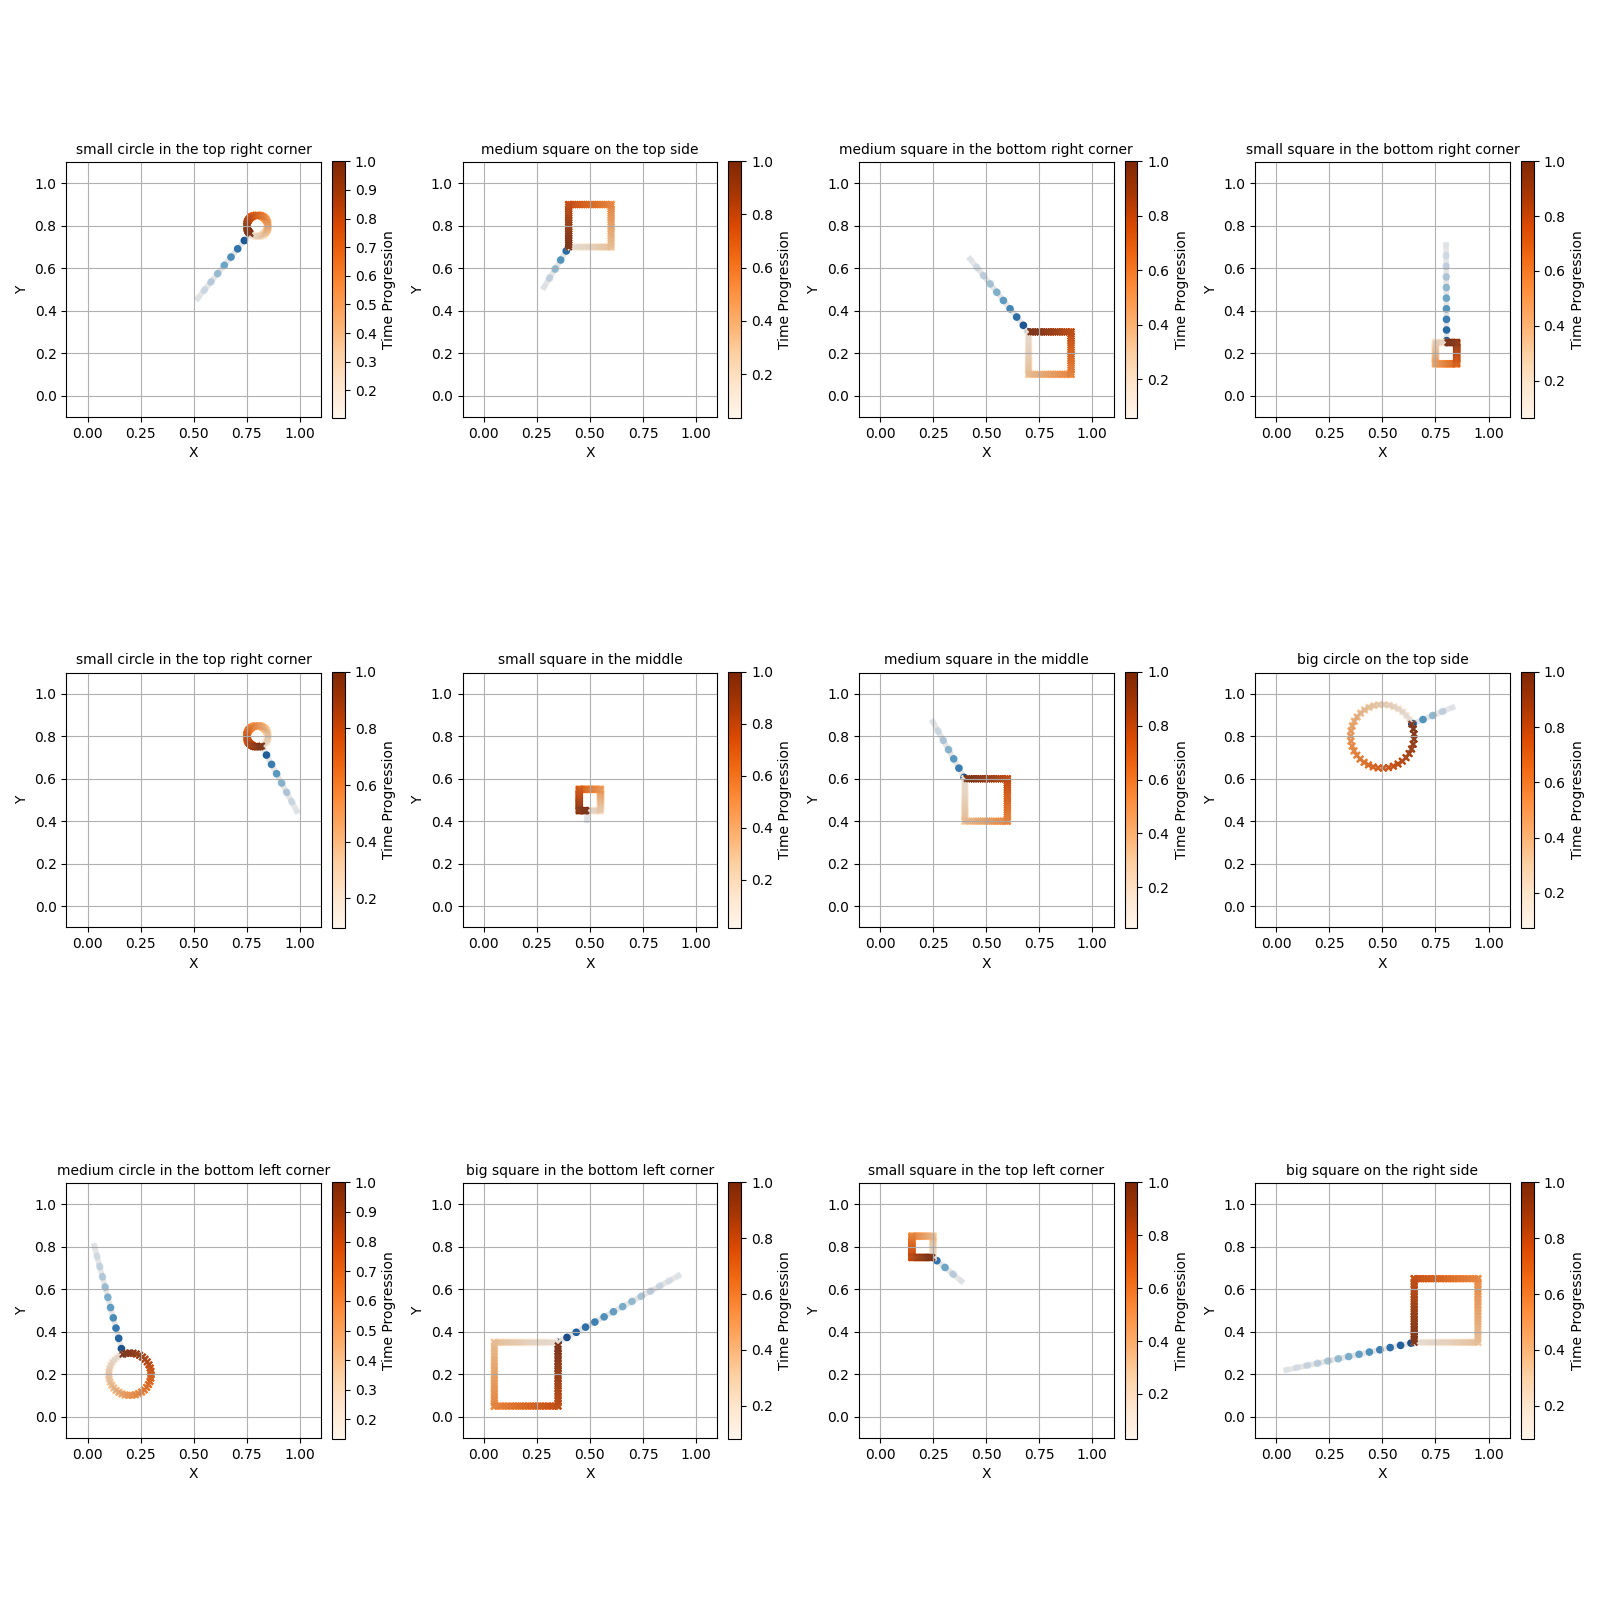

In [12]:
!python /content/LangPathModel/data/data_visualization.py /content/CaptyShapes/all_shapes.pt
display(Image("visualization.png"))

###**Training**

In [13]:
!python LangPathModel/src/training.py \
  --niter 100 \
  --start_lr 0.001 \
  --lr_step 10 \
  --weight_decay 1e-5 \
  --d_model 64 \
  --num_heads 8 \
  --num_decoder_layers 2 \
  --dropout 0.2 \
  --gamma 0.1 \
  --batch_size 500 \
  --dataset_path /content/CaptyShapes/all_shapes.pt \
  --output_path /new_model.pth \
  --ckpt_path /content/LangPathModel/checkpoints
#for testing use small_dataset.pt instead of all shapes.pt

2025-06-03 12:57:15.890502: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748955435.911855    4355 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748955435.918290    4355 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
model.safetensors: 100% 440M/440M [00:01<00:00, 341MB/s]
input_embedding.weight: cuda:0
input_embedding.bias: cuda:0
text_encoder.bert.embeddings.word_embeddings.weight: cuda:0
text_encoder.bert.embeddings

###**Evaluate**

In [14]:
#doesnt work
!python src/evaluate_model.py \
        --model_path trained_models/best_model.pth \
        --text "bottom circle" \
        --save out.gif


python3: can't open file '/content/src/evaluate_model.py': [Errno 2] No such file or directory


In [15]:
#temporary testing ground
import torch
import sys
sys.path.append('/content/drive/MyDrive')
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
from LangPathModel.src.textEncoders import TextEncoder
from LangPathModel.src.nn import LangPathModel
from transformers import AutoTokenizer

d_model = 64
model = LangPathModel(d_model=d_model, num_heads_decoder=8, num_decoder_layers=2, dropout = 0.2)
model.eval()
# Step 2: Load the saved state dict
model.load_state_dict(torch.load('/content/LangPathModel/checkpoints/model_state_epoch_020.pth', map_location='cuda' if torch.cuda.is_available() else 'cpu'))

# Step 3: Move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.positional_encoding = model.positional_encoding.to(device)  # This line was added

# Initialize tokenizer and encoder
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
text_encoder = TextEncoder(output_dim=d_model)

# Text and encoding
text = "medium circle in middle"
encoded = tokenizer(text, padding=True, truncation=True, return_tensors='pt')

# **Instead of directly using text_encoder output, use encoded['input_ids'] and encoded['attention_mask']**
# txt = text_encoder(encoded['input_ids'], encoded['attention_mask'])
txt = encoded['input_ids'].to(device)
txt_mask = (encoded['attention_mask'] == 0).to(device)


path_mask = torch.Tensor([[1, 1]]).to(device)
print(path_mask.shape)

# Iniptialize starting point
start = torch.Tensor([[[0.1, 0.9, 0, 0]]]).to(device)  # (1, 1, 4)
#tgt = torch.empty([1, 1, 4]).to(device)  # (1, 1, 4)
tgt = start
# Store predictions
positions = [start[0, 0, :2].clone().cpu().numpy()]

# Loop to generate 200 predictions
for i in range(200):
    with torch.no_grad():
        prediction = model(
            text=txt,
            tgt=tgt,
            text_mask=txt_mask,
            path_mask=path_mask
        )  # Output shape: (1, seq_len+1, 4
    next_point = prediction[:, -1, :]  # Get the last predicted point
    #print(next_point)
    positions.append(next_point[0, :2].cpu().numpy())  # Save (x, y)

    # Append next_point to tgt for next prediction
    tgt = torch.cat([tgt, next_point.unsqueeze(1)], dim=1)
    path_mask = torch.cat([path_mask, torch.ones((1, 1)).to(device)], dim=1)
    print(path_mask.shape)
    #print(tgt[0, :, :
    if next_point[0, 3] > 0.5: break
    #print(next_point[0, 3])

# Convert predictions to numpy array
positions = np.array(positions)  # shape: (num_points, 2)
actions = tgt[0, :, 2].cpu().numpy()  # shape: (num_points,) - only 'a' values
#print(positions)
# Bin actions
binned_actions = (actions >= 0.5).astype(int)  # 0 if a < 0.5, 1 otherwise

# Plot
plt.figure(figsize=(8, 6))
for i in range(len(positions)):
    x, y = positions[i]
    if binned_actions[i] == 0:
        plt.scatter(x, y,color='blue', label='Action = 0' if i == 0 else "", s=50)
    else:
        plt.scatter(x, y, color='red', label='Action = 1' if i == 0 else "", s=50)

plt.title("Generated Path with Binned Actions (0=blue, 1=red)")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)

plt.legend()
plt.gca().set_aspect('equal')
plt.grid(True)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/LangPathModel/checkpoints/model_state_epoch_020.pth'

###**Add velocities and export it as csv**

In [ ]:
#to do
#vels = path2vels(path)
#path = [path, vels]
#save to csv